<font size="10">Classification</font>

<font size="8">kNN on Alzheimers Data</font>

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import np_utils




data = pd.read_csv("Alzheimer's.csv")

#Converted the group to dummy variables
data.loc[data.Group=='Nondemented', 'Group'] = 0
data.loc[data.Group=='Demented', 'Group'] = 1
data.loc[data.Group=='Converted', 'Group'] = 2

#Converted the M/F to dummy variables
data.loc[data.Sex=='M', 'Sex'] = 0
data.loc[data.Sex=='F', 'Sex'] = 1


data

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,Mini Mental State,Clinical Dementia Rating,Estimated total Intracranial Volume,Normalize Whole Brain Volume,Atlas Scaling Factor
0,OAS2_0001,OAS2_0001_MR1,0,1,0,0,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,0,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,0,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,0,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,0,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1,2,842,0,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1,3,2297,0,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0,1,0,1,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0,2,763,1,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [2]:
#PCA might be a good technique to select predictors 

#note that PCA performs best when data is normalized (range b/w 0 and 1)

#It is possible to use categorical and continuous predictors 
#for a regression problem. My understanding is you need to make 
#dummy variables for the binary predictors. 

#Variables that we will need to deal with: 
# Hand, Visit, Subject ID, MRI ID

In [3]:
#Attempting PCA on data
#Hand is completely useless as it is identical for all samples
data_drop = data.drop(['Hand','Visit','Subject ID','MRI ID'], axis = 1) #axis = 1 means to drop column not row

#get rid of row 360 and 359 bc they are missing alot of data (both SES and MMS)
data_drop = data_drop.drop([360, 359])


#delete all data points that dont have SES in them (this is where they have NaN)
data_drop = data_drop.dropna()

#dementia status is what we want to predict - change this to single target 
group = data_drop[['Group']] 



data_drop = data_drop.drop(['Group'], axis = 1) #axis = 1 means to drop column not row

data_drop


,MR Delay,Sex,Age,EDUC,SES,Mini Mental State,Clinical Dementia Rating,Estimated total Intracranial Volume,Normalize Whole Brain Volume,Atlas Scaling Factor
0,0,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,457,0,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,0,1,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,538,1,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,0,0,80,12,4.0,28.0,0.0,1689,0.712,1.039
...,...,...,...,...,...,...,...,...,...,...
368,842,0,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,2297,0,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,0,1,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,763,1,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [4]:
#get a list of columns in pandas object 
names_of_data = data_drop.columns.tolist()

#shuffle = false prevents data split being different everytime
X_train, X_test, y_train, y_test = train_test_split(data_drop, group, test_size=0.2, shuffle = False)

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [5]:
#running the actual PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
print(len(explained_variance))
print(explained_variance)

10
[0.2790578  0.21909196 0.14981908 0.12851434 0.08639602 0.05229841
 0.03160894 0.02928376 0.02278443 0.00114525]


In [6]:
#As we can see, the principal components contribute to 27%. As a result of not having any 
#variables strongly contributing to the variance, we will not drop any variables

In [7]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

from sklearn.neighbors import KNeighborsClassifier
accuracy = list()

#Find which one gets the highest accuracy
for K in range(1,30):
    #K = K+1
    classifier = KNeighborsClassifier(n_neighbors = K)

    classifier.fit(X_train, y_train)  #fit the model
    y_pred = classifier.predict(X_test)
    

    accuracy.append(accuracy_score(y_test,y_pred)) #store rmse values
    print('accuracy value for k= ' , K , 'is:', accuracy[K-1])
    
max_value = max(accuracy)
best_k_value = accuracy.index(max_value) + 1
classifier = KNeighborsClassifier(n_neighbors=best_k_value, weights = 'distance')
classifier.fit(X_train, y_train) 
#relief f algorithm - sorting features 

/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':
/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':
/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':
/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

accuracy value for k=  1 is: 0.7605633802816901
accuracy value for k=  2 is: 0.7746478873239436
accuracy value for k=  3 is: 0.7746478873239436
accuracy value for k=  4 is: 0.7887323943661971
accuracy value for k=  5 is: 0.7605633802816901
accuracy value for k=  6 is: 0.7605633802816901
accuracy value for k=  7 is: 0.7605633802816901
accuracy value for k=  8 is: 0.7605633802816901
accuracy value for k=  9 is: 0.7605633802816901
accuracy value for k=  10 is: 0.7605633802816901
accuracy value for k=  11 is: 0.7605633802816901
accuracy value for k=  12 is: 0.7605633802816901
accuracy value for k=  13 is: 0.7464788732394366
accuracy value for k=  14 is: 0.7605633802816901
accuracy value for k=  15 is: 0.7746478873239436
accuracy value for k=  16 is: 0.7605633802816901
accuracy value for k=  17 is: 0.7605633802816901
accuracy value for k=  18 is: 0.7605633802816901
accuracy value for k=  19 is: 0.7464788732394366
accuracy value for k=  20 is: 0.7464788732394366
accuracy value for k=  21 is:

/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':
/Users/RJ/Desktop/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [12]:
y_pred = classifier.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
results = classification_report(y_test, y_pred)
results[0]

print("The highest accuracy was found to be: " + str(accuracy_score(y_test,y_pred)))

[[38  0  0]
 [ 4 17  5]
 [ 3  3  1]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        38
           1       0.85      0.65      0.74        26
           2       0.17      0.14      0.15         7

    accuracy                           0.79        71
   macro avg       0.62      0.60      0.60        71
weighted avg       0.78      0.79      0.78        71

The highest accuracy was found to be: 0.7887323943661971


In [13]:
x_vector = np.linspace(0, len(X_test),len(X_test) )


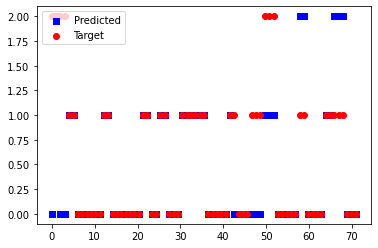

In [14]:
import matplotlib.pyplot as plt

x = range(100)
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_vector, y_pred, c='b', marker="s", label='Predicted')
ax1.scatter(x_vector, y_test, c='r', marker="o", label='Target')
plt.legend(loc='upper left');
plt.show()

In [11]:
#Here we can see the difference between the predicted and target values